In [192]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [8]:
training_data = pd.read_csv('well_data.csv')

# 데이터 시각화

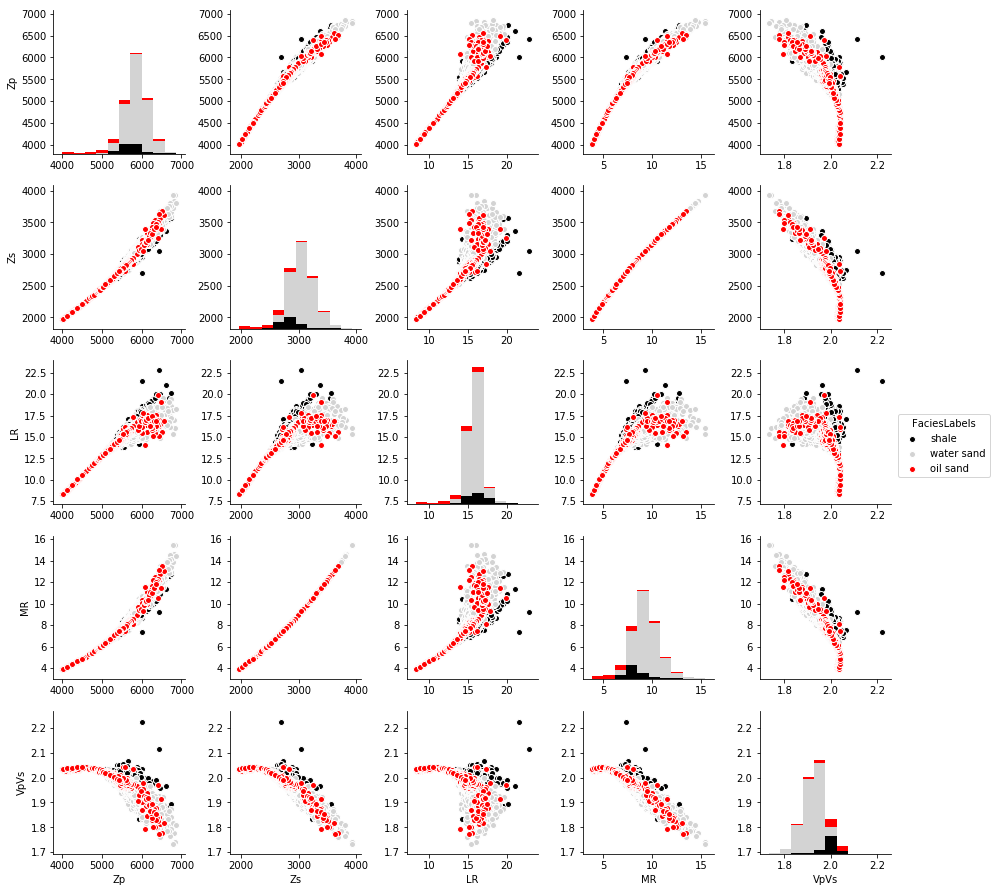

In [9]:
facies_colors = ['#000000', '#D3D3D3', '#ff0000']
facies_labels = ['shale', 'water sand', 'oil sand']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ int(row['label'])]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

import seaborn as sns
sns.pairplot(training_data.drop(['label'], axis=1),
             hue="FaciesLabels", palette=facies_color_map, hue_order=list(facies_labels))

# 훈련/검증 셋 분리

In [20]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_data, test_size=0.2, stratify=training_data['label'],
                                      random_state=10)

In [21]:
train_set['label'].value_counts() / len(train_set)

1    0.814044
0    0.103056
2    0.082900
Name: label, dtype: float64

In [22]:
val_set['label'].value_counts() / len(val_set)

1    0.814044
0    0.102731
2    0.083225
Name: label, dtype: float64

In [23]:
X_all = training_data.drop(['label', 'FaciesLabels'], axis=1).values
y_all = training_data['label'].values

X_train = train_set.drop(['label', 'FaciesLabels'], axis=1).values
y_train = train_set['label'].values

X_val = val_set.drop(['label', 'FaciesLabels'], axis=1).values
y_val = val_set['label'].values

# 특성 스케일링

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 모델 훈련

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=10)

rnd_clf = RandomForestClassifier(n_estimators=10, max_depth=8, random_state=10)

gbst_clf = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=10)

lgst_clf = LogisticRegression(C=100)

svm_clf = SVC(kernel="rbf", gamma=1, C=1, degree=1, probability=True)

for clf in (tree_clf, rnd_clf, gbst_clf, lgst_clf, svm_clf):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_val_scaled)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))
        

DecisionTreeClassifier 0.911573472042
RandomForestClassifier 0.927178153446
GradientBoostingClassifier 0.914174252276
LogisticRegression 0.91677503251
SVC 0.921976592978


# Grid search

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Cs = np.logspace(-4, 4, 3)
gammas = np.logspace(-4, 4, 1)
degrees = [ 1, 3]

pipe= Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='rbf'))
    ])

grid_search = GridSearchCV(pipe, dict(svm_clf__C=Cs, svm_clf__gamma=gammas, svm_clf__degree=degrees), cv=5)
grid_search.fit(X_all, y_all.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svm_clf__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04]), 'svm_clf__gamma': array([ 0.0001]), 'svm_clf__degree': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [92]:
grid_search.best_params_

{'svm_clf__C': 10000.0, 'svm_clf__degree': 1, 'svm_clf__gamma': 0.0001}

# DNN 학습


In [193]:
reset_graph()

n_inputs = 5 
n_hidden1 = 32
n_hidden2 = 64
n_hidden3 = 32
n_outputs = 3

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int64, shape=(None))
training = tf.placeholder_with_default(False, shape=())

hidden1= tf.layers.dense(X, n_hidden1)
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.leaky_relu(bn1)

hidden2= tf.layers.dense(bn1_act, n_hidden2)
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.leaky_relu(bn2)

hidden3= tf.layers.dense(bn2_act, n_hidden3)
bn3 = tf.layers.batch_normalization(hidden3, training=training, momentum=0.9)
bn3_act = tf.nn.leaky_relu(bn3)

logits =tf.layers.dense(bn3_act, n_outputs) 
prediction = tf.argmax(logits, axis=1)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()
moving_average_update_op = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

n_samples = len(X_train_scaled)
def fetch_batch(batch_size, epoch, iteration):
    np.random.seed(epoch)
    shuffled_indices = np.random.permutation(n_samples)
    batch_indices = shuffled_indices[iteration * batch_size:(iteration+1)*batch_size]
    return X_train_scaled[batch_indices, :], y_train[batch_indices]


n_epochs = 100
batch_size = 32
highest_acc = 0.0

init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_samples // batch_size):            
            X_batch, y_batch = fetch_batch(batch_size, epoch, iteration)
            sess.run([training_op, moving_average_update_op],
                     feed_dict={X: X_batch, y: y_batch, training: True})        
           
        acc_train = accuracy.eval(feed_dict={X: X_train_scaled, y: y_train})
        acc_val = accuracy.eval(feed_dict={X: X_val_scaled, y: y_val})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        
        if acc_val > highest_acc:
            save_path = saver.save(sess, "./models/best_model.ckpt")
            highest_acc = acc_val


0 Train accuracy: 0.928153 Val accuracy: 0.925878
1 Train accuracy: 0.927503 Val accuracy: 0.911573
2 Train accuracy: 0.921001 Val accuracy: 0.925878
3 Train accuracy: 0.930104 Val accuracy: 0.927178
4 Train accuracy: 0.931729 Val accuracy: 0.924577
5 Train accuracy: 0.928804 Val accuracy: 0.929779
6 Train accuracy: 0.925228 Val accuracy: 0.925878
7 Train accuracy: 0.921326 Val accuracy: 0.90117
8 Train accuracy: 0.926528 Val accuracy: 0.924577
9 Train accuracy: 0.921651 Val accuracy: 0.910273
10 Train accuracy: 0.929779 Val accuracy: 0.925878
11 Train accuracy: 0.930754 Val accuracy: 0.925878
12 Train accuracy: 0.925878 Val accuracy: 0.924577
13 Train accuracy: 0.928479 Val accuracy: 0.923277
14 Train accuracy: 0.930104 Val accuracy: 0.928479
15 Train accuracy: 0.929779 Val accuracy: 0.927178
16 Train accuracy: 0.930104 Val accuracy: 0.924577
17 Train accuracy: 0.926203 Val accuracy: 0.927178
18 Train accuracy: 0.931079 Val accuracy: 0.927178
19 Train accuracy: 0.931079 Val accuracy: 

# 예측 및 검증

In [194]:
pred_tree = tree_clf.predict(X_val_scaled)
pred_rnd = rnd_clf.predict(X_val_scaled)
pred_gbst = gbst_clf.predict(X_val_scaled)
pred_lgst = lgst_clf.predict(X_val_scaled)
pred_svm = svm_clf.predict(X_val_scaled)

with tf.Session() as sess:
    saver.restore(sess, "./models/best_model.ckpt")    
    pred_dnn = prediction.eval(feed_dict={X: X_val_scaled})   
    

INFO:tensorflow:Restoring parameters from ./models/best_model.ckpt


In [195]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
clf_names = ['Decision tree', 'Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'DNN']

for index, pred in enumerate((pred_tree, pred_rnd, pred_gbst, pred_lgst, pred_svm, pred_dnn)):
    print('###',index + 1, clf_names[index],'###')
    print('Accuracy : ', accuracy_score(y_val, pred))
    print('Precision: ', precision_score(y_val, pred, average=None))
    print('Recall   : ', recall_score(y_val, pred, average=None))
    print('f1_score : ', f1_score(y_val, pred, average=None))
    print('confusion matrix:')
    print(confusion_matrix(y_val, pred))
    print()


### 1 Decision tree ###
Accuracy :  0.911573472042
Precision:  [ 0.83333333  0.92433234  0.8       ]
Recall   :  [ 0.63291139  0.99520767  0.4375    ]
f1_score :  [ 0.71942446  0.95846154  0.56565657]
confusion matrix:
[[ 50  24   5]
 [  1 623   2]
 [  9  27  28]]

### 2 Random Forest ###
Accuracy :  0.927178153446
Precision:  [ 0.83098592  0.93674699  0.94117647]
Recall   :  [ 0.74683544  0.99361022  0.5       ]
f1_score :  [ 0.78666667  0.96434109  0.65306122]
confusion matrix:
[[ 59  18   2]
 [  4 622   0]
 [  8  24  32]]

### 3 Gradient Boosting ###
Accuracy :  0.914174252276
Precision:  [ 0.81944444  0.93990755  0.70833333]
Recall   :  [ 0.74683544  0.97444089  0.53125   ]
f1_score :  [ 0.78145695  0.95686275  0.60714286]
confusion matrix:
[[ 59  17   3]
 [  5 610  11]
 [  8  22  34]]

### 4 Logistic Regression ###
Accuracy :  0.91677503251
Precision:  [ 0.84722222  0.92921687  0.81818182]
Recall   :  [ 0.7721519  0.985623   0.421875 ]
f1_score :  [ 0.80794702  0.95658915  0.55670

# 탄성파에 적용

In [196]:
Zp = pd.read_excel('Zp_section.xlsx').values
Zs = pd.read_excel('Zs_section.xlsx').values
LR = pd.read_excel('LR_section.xlsx').values
MR = pd.read_excel('MR_section.xlsx').values
VpVs = pd.read_excel('VpVs_section.xlsx').values

mask = Zp.copy()
mask[mask != 0] = 1
mask[mask == 0] = np.nan

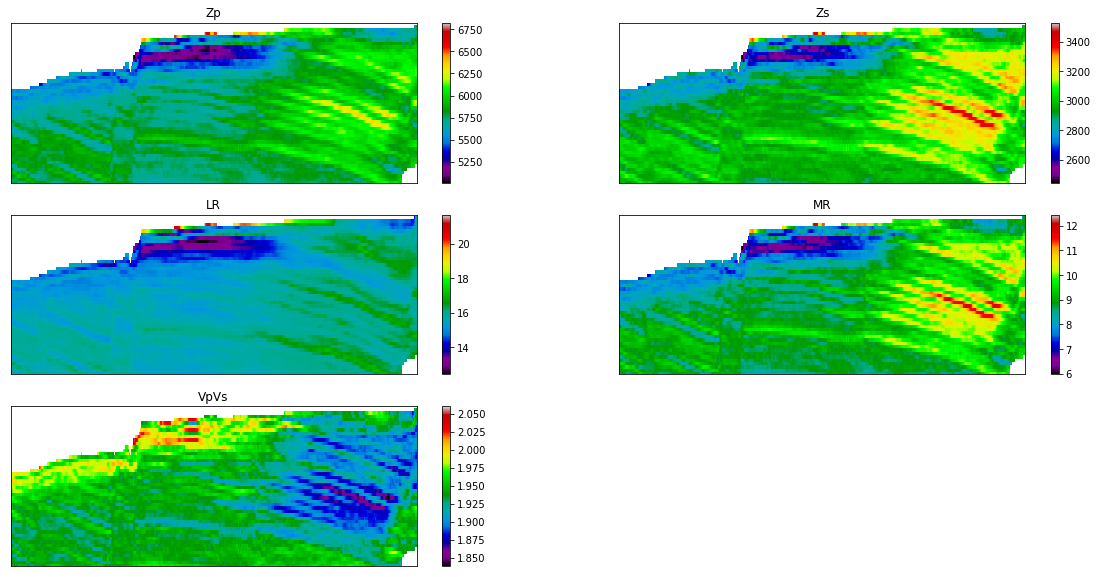

In [197]:
plt.figure(figsize=(20,10))
att_names = ['Zp', 'Zs', 'LR', 'MR', 'VpVs']
for index, attibute in enumerate((Zp, Zs, LR, MR, VpVs)):
    plt.subplot('32{}'.format(index+1))
    plt.ylim([90, 43])   
    plt.imshow(attibute * mask, interpolation='none', aspect='auto', cmap='nipy_spectral')
    plt.title(att_names[index])
    plt.colorbar()
    plt.tick_params(
        axis='both',          
        which='both',     
        bottom=False,
        left=False,     
        labelbottom=False,
        labelleft=False
    )
    


In [198]:
mask = Zp.copy()
mask[mask != 0] = 1
mask[mask == 0] = np.nan

nx, ny = Zp.shape
Zp = Zp.reshape(-1, 1)
Zs = Zs.reshape(-1, 1)
LR = LR.reshape(-1, 1)
MR = MR.reshape(-1, 1)
VpVs = VpVs.reshape(-1, 1)

X_new = np.hstack([Zp, Zs, LR, MR, VpVs])
X_new_scaled = scaler.transform(X_new)

In [200]:
pred_tree = tree_clf.predict(X_new_scaled)
pred_rnd = rnd_clf.predict(X_new_scaled)
pred_gbst = gbst_clf.predict(X_new_scaled)
pred_lgst = lgst_clf.predict(X_new_scaled)
pred_svm = svm_clf.predict(X_new_scaled)

with tf.Session() as sess:
    saver.restore(sess, "./models/best_model.ckpt")
    pred_dnn = prediction.eval(feed_dict={X: X_new_scaled})

INFO:tensorflow:Restoring parameters from ./models/best_model.ckpt


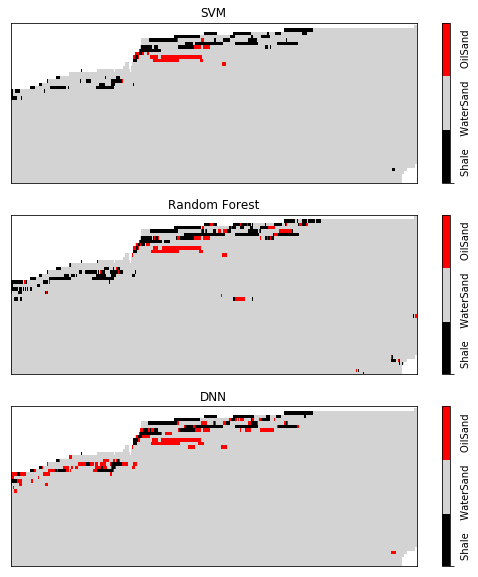

In [201]:
cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
from mpl_toolkits.axes_grid1 import make_axes_locatable
clf_names = ['SVM', 'Random Forest', 'DNN']

plt.figure(figsize=(20,10))
for index, pred in enumerate((pred_svm, pred_rnd, pred_dnn)):
    plt.subplot('32{}'.format(2*index+1))
    plt.ylim([90, 43])
    pred_reshaped = pred.reshape(nx, ny)
    
    plt.imshow(pred_reshaped * mask, interpolation='none', aspect='auto', cmap=cmap_facies)
    plt.title(clf_names[index])
    
    cbar = plt.colorbar()
    cbar.set_label((4*' ').join(['Shale',  'WaterSand', 'OilSand']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    plt.tick_params(
        axis='both',          
        which='both',     
        bottom=False,
        left=False,     
        labelbottom=False,
        labelleft=False
    )